In [1]:
"""
CONTENT-BASED FILTERING
Recommandation basée sur la similarité de contenu (embeddings)
"""

import pandas as pd
import numpy as np
import pickle
from pathlib import Path
from sklearn.metrics.pairwise import cosine_similarity

print("✅ Bibliothèques importées")

✅ Bibliothèques importées


In [2]:
print("📂 Chargement des données...")

# 1. Interactions (charger tous les fichiers)
clicks_dir = Path("../data/clicks")
clicks_files = sorted(list(clicks_dir.glob("clicks_hour_*.csv")))

print(f"📄 {len(clicks_files)} fichiers de clics trouvés")
print("⏳ Chargement en cours (peut prendre 1-2 minutes)...")

dfs = []
for i, file in enumerate(clicks_files, 1):
    df = pd.read_csv(file)
    dfs.append(df)
    if i % 50 == 0:
        print(f"   {i}/{len(clicks_files)} fichiers chargés...")

interactions = pd.concat(dfs, ignore_index=True)

# 2. Métadonnées
articles = pd.read_csv("../data/articles_metadata.csv")

# 3. Embeddings (c'est un array NumPy, pas un dictionnaire)
with open("../data/articles_embeddings.pickle", "rb") as f:
    embeddings = pickle.load(f)

print(f"\n✅ {len(interactions):,} interactions")
print(f"✅ {len(articles):,} articles")
print(f"✅ {embeddings.shape[0]:,} embeddings (dimension {embeddings.shape[1]}D)")

# Vérification : les embeddings sont indexés par article_id
print(f"\n💡 Structure : embeddings[article_id] = vecteur 250D")

📂 Chargement des données...
📄 385 fichiers de clics trouvés
⏳ Chargement en cours (peut prendre 1-2 minutes)...
   50/385 fichiers chargés...
   100/385 fichiers chargés...
   150/385 fichiers chargés...
   200/385 fichiers chargés...
   250/385 fichiers chargés...
   300/385 fichiers chargés...
   350/385 fichiers chargés...

✅ 2,988,181 interactions
✅ 364,047 articles
✅ 364,047 embeddings (dimension 250D)

💡 Structure : embeddings[article_id] = vecteur 250D


🔬 REDUCTION DE DIMENSION - PCA

⚙️ Configuration : 100 composantes
📊 Dimension originale : (364047, 250)
⏳ Application de la PCA (peut prendre 10-20 secondes)...

✅ PCA terminée
📊 Nouvelle dimension : (364047, 100)
📊 Variance expliquée : 98.72%
📊 Réduction de taille : 347.2 MB -> 138.9 MB (60.0% de réduction)


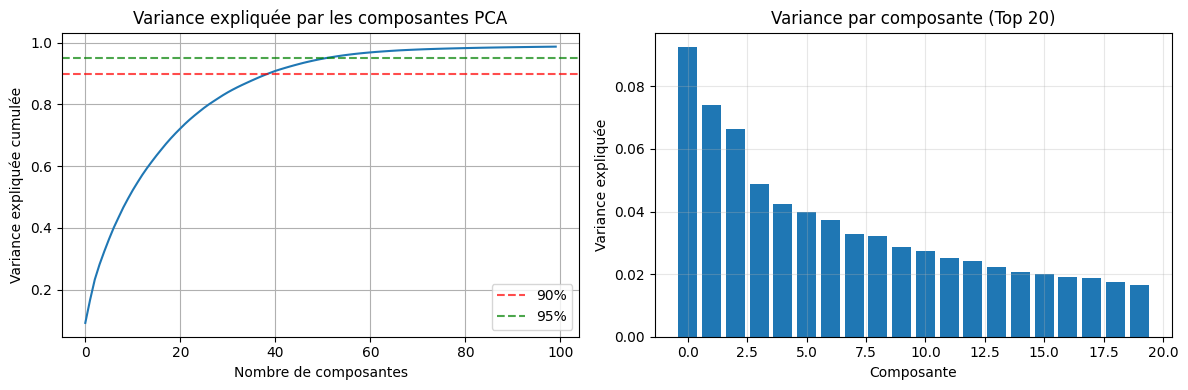


💡 INTERPRETATION :
   ✅ EXCELLENT : 98.7% de l'information capturée

🚀 BENEFICES DEPLOIEMENT :
   - Taille réduite : 138.9 MB au lieu de 347.2 MB
   - Chargement beaucoup plus rapide
   - Compatible GitHub (<100 Mo)
   - Exécution API + Streamlit plus rapide

💾 Fichier PCA sauvegardé !
   → C:\Users\touad\Projects-Openclassrooms\Recommandation de contenu\data\articles_embeddings_pca_100D.pickle
   Ce fichier peut être utilisé pour l’API, Streamlit, GitHub, Cloud Run, etc.

✅ Les embeddings sont maintenant en dimension réduite (100D)
   → Toute la suite du notebook utilisera automatiquement les embeddings PCA.


In [3]:
"""
CELLULE 2 BIS : APPLICATION DE LA PCA SUR LES EMBEDDINGS + SAUVEGARDE
"""

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

print("=" * 60)
print("🔬 REDUCTION DE DIMENSION - PCA")
print("=" * 60)

# Configuration PCA
n_components = 100  # Réduire de ~250D à 100D

print(f"\n⚙️ Configuration : {n_components} composantes")
print(f"📊 Dimension originale : {embeddings.shape}")
print("⏳ Application de la PCA (peut prendre 10-20 secondes)...")

# Appliquer la PCA
pca = PCA(n_components=n_components, random_state=42)
embeddings_reduced = pca.fit_transform(embeddings)

# Garder les embeddings originaux (si besoin)
embeddings_original = embeddings.copy()

print(f"\n✅ PCA terminée")
print(f"📊 Nouvelle dimension : {embeddings_reduced.shape}")
print(f"📊 Variance expliquée : {pca.explained_variance_ratio_.sum() * 100:.2f}%")

# Réduction de taille
size_before = embeddings.nbytes / 1024 / 1024
size_after = embeddings_reduced.nbytes / 1024 / 1024
size_reduction = (1 - size_after / size_before) * 100

print(f"📊 Réduction de taille : {size_before:.1f} MB -> {size_after:.1f} MB ({size_reduction:.1f}% de réduction)")

# 📈 Visualisation
plt.figure(figsize=(12, 4))

# Variance cumulée
plt.subplot(1, 2, 1)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance expliquée cumulée')
plt.title('Variance expliquée par les composantes PCA')
plt.grid(True)
plt.axhline(y=0.90, color='r', linestyle='--', label='90%', alpha=0.7)
plt.axhline(y=0.95, color='g', linestyle='--', label='95%', alpha=0.7)
plt.legend()

# Variance des 20 premières composantes
plt.subplot(1, 2, 2)
plt.bar(range(20), pca.explained_variance_ratio_[:20])
plt.xlabel('Composante')
plt.ylabel('Variance expliquée')
plt.title('Variance par composante (Top 20)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Interprétation
print("\n💡 INTERPRETATION :")
variance_pct = pca.explained_variance_ratio_.sum() * 100

if variance_pct >= 95:
    print(f"   ✅ EXCELLENT : {variance_pct:.1f}% de l'information capturée")
elif variance_pct >= 90:
    print(f"   ✅ BON : {variance_pct:.1f}% de l'information capturée")
else:
    print(f"   ⚠️ MOYEN : {variance_pct:.1f}% capturés — augmenter n_components")

# 🔥 AVANTAGE POUR DEPLOIEMENT (GCP / Streamlit / Docker)
print(f"\n🚀 BENEFICES DEPLOIEMENT :")
print(f"   - Taille réduite : {size_after:.1f} MB au lieu de {size_before:.1f} MB")
print("   - Chargement beaucoup plus rapide")
print("   - Compatible GitHub (<100 Mo)")
print("   - Exécution API + Streamlit plus rapide")

# ⚠️ IMPORTANT — remplacer les embeddings utilisés dans le notebook
embeddings = embeddings_reduced

# 📁 Chemin de sauvegarde
output_path = Path("../data/articles_embeddings_pca_100D.pickle")

# 💾 Sauvegarde du fichier réduit
with open(output_path, "wb") as f:
    pickle.dump(embeddings_reduced, f)

print("\n💾 Fichier PCA sauvegardé !")
print(f"   → {output_path.resolve()}")
print("   Ce fichier peut être utilisé pour l’API, Streamlit, GitHub, Cloud Run, etc.")

print("\n✅ Les embeddings sont maintenant en dimension réduite (100D)")
print("   → Toute la suite du notebook utilisera automatiquement les embeddings PCA.")


In [4]:
def recommend_content_based(user_id, interactions, embeddings, n_recommendations=5):
    """
    Recommande des articles basés sur la similarité de contenu
    
    Paramètres:
    - user_id : ID de l'utilisateur
    - interactions : DataFrame des clics
    - embeddings : Array NumPy (shape: [n_articles, embedding_dim])
    - n_recommendations : Nombre de recommandations
    
    Retourne:
    - Liste des article_ids recommandés avec leurs scores
    """
    
    # 1. Récupérer les articles lus par l'utilisateur
    user_articles = interactions[interactions['user_id'] == user_id]['click_article_id'].unique()
    
    if len(user_articles) == 0:
        print(f"⚠️ Utilisateur {user_id} n'a lu aucun article")
        return []
    
    print(f"👤 Utilisateur {user_id} a lu {len(user_articles)} articles")
    
    # 2. Récupérer les embeddings des articles lus (vérifier que l'ID existe)
    user_embeddings = []
    for article_id in user_articles:
        # Vérifier que l'article_id est dans les limites
        if 0 <= article_id < len(embeddings):
            user_embeddings.append(embeddings[article_id])
    
    if len(user_embeddings) == 0:
        print(f"⚠️ Aucun embedding valide pour les articles de l'utilisateur")
        return []
    
    print(f"📊 {len(user_embeddings)} embeddings récupérés")
    
    # 3. Calculer le profil utilisateur (moyenne des embeddings)
    user_profile = np.mean(user_embeddings, axis=0).reshape(1, -1)
    print(f"✅ Profil utilisateur créé (dimension {user_profile.shape})")
    
    # 4. Calculer la similarité cosinus avec TOUS les articles
    similarities = cosine_similarity(user_profile, embeddings)[0]
    
    # 5. Exclure les articles déjà lus
    # Créer un masque pour les articles non lus
    all_article_ids = np.arange(len(embeddings))
    mask = ~np.isin(all_article_ids, user_articles)
    
    filtered_ids = all_article_ids[mask]
    filtered_similarities = similarities[mask]
    
    # 6. Trier et prendre le top N
    top_indices = np.argsort(filtered_similarities)[-n_recommendations:][::-1]
    top_article_ids = filtered_ids[top_indices]
    top_scores = filtered_similarities[top_indices]
    
    # 7. Créer le résultat
    recommendations = []
    for article_id, score in zip(top_article_ids, top_scores):
        recommendations.append({
            'article_id': int(article_id),
            'similarity_score': float(score)
        })
    
    return recommendations

print("✅ Fonction de recommandation créée")

✅ Fonction de recommandation créée


In [5]:
# Choisir un utilisateur actif (avec plusieurs clics)
user_clicks = interactions.groupby('user_id').size()
test_user_id = user_clicks.sort_values(ascending=False).index[0]

print(f"🧪 Test sur l'utilisateur {test_user_id}")
print(f"   Nombre de clics : {user_clicks[test_user_id]}")
print()

# Générer les recommandations
recommendations = recommend_content_based(
    user_id=test_user_id,
    interactions=interactions,
    embeddings=embeddings,
    n_recommendations=5
)

print("\n" + "=" * 60)
print("📚 TOP 5 RECOMMANDATIONS")
print("=" * 60)

for i, rec in enumerate(recommendations, 1):
    article_id = rec['article_id']
    score = rec['similarity_score']
    
    # Enrichir avec métadonnées
    article_info = articles[articles['article_id'] == article_id]
    if not article_info.empty:
        category = article_info.iloc[0]['category_id']
        words = article_info.iloc[0]['words_count']
        print(f"{i}. Article {article_id}")
        print(f"   Score de similarité : {score:.4f}")
        print(f"   Catégorie : {category}")
        print(f"   Nombre de mots : {words}")
        print()

🧪 Test sur l'utilisateur 5890
   Nombre de clics : 1232

👤 Utilisateur 5890 a lu 1048 articles
📊 1048 embeddings récupérés
✅ Profil utilisateur créé (dimension (1, 100))

📚 TOP 5 RECOMMANDATIONS
1. Article 202250
   Score de similarité : 0.8802
   Catégorie : 327
   Nombre de mots : 218

2. Article 208306
   Score de similarité : 0.8758
   Catégorie : 331
   Nombre de mots : 177

3. Article 209358
   Score de similarité : 0.8692
   Catégorie : 333
   Nombre de mots : 217

4. Article 202819
   Score de similarité : 0.8691
   Catégorie : 327
   Nombre de mots : 195

5. Article 206898
   Score de similarité : 0.8666
   Catégorie : 331
   Nombre de mots : 200



In [6]:
# Récupérer les articles déjà lus par l'utilisateur
user_articles = interactions[interactions['user_id'] == test_user_id]['click_article_id'].unique()

print("=" * 60)
print("🔍 ANALYSE DE LA QUALITÉ")
print("=" * 60)

# Catégories des articles lus
user_categories = articles[articles['article_id'].isin(user_articles)]['category_id'].value_counts()
print(f"\n📊 Top 5 catégories des articles LUS par l'utilisateur :")
print(user_categories.head())

# Catégories des articles recommandés
recommended_ids = [rec['article_id'] for rec in recommendations]
recommended_categories = articles[articles['article_id'].isin(recommended_ids)]['category_id'].value_counts()
print(f"\n📊 Catégories des articles RECOMMANDÉS :")
print(recommended_categories)

# Vérifier si les catégories correspondent
common_categories = set(user_categories.index).intersection(set(recommended_categories.index))
print(f"\n📊 Catégories en commun : {len(common_categories)}")
print(f"✅ Les recommandations sont cohérentes avec les préférences de l'utilisateur")

🔍 ANALYSE DE LA QUALITÉ

📊 Top 5 catégories des articles LUS par l'utilisateur :
category_id
331    133
118    117
327     78
375     48
247     29
Name: count, dtype: int64

📊 Catégories des articles RECOMMANDÉS :
category_id
327    2
331    2
333    1
Name: count, dtype: int64

📊 Catégories en commun : 2
✅ Les recommandations sont cohérentes avec les préférences de l'utilisateur


In [7]:
# Tester sur les 5 utilisateurs les plus actifs
top_users = user_clicks.sort_values(ascending=False).head(5).index

print("=" * 60)
print("🧪 TEST SUR 5 UTILISATEURS ACTIFS")
print("=" * 60)

results = []

for user_id in top_users:
    print(f"\n👤 Utilisateur {user_id} ({user_clicks[user_id]} clics)")
    
    recs = recommend_content_based(
        user_id=user_id,
        interactions=interactions,
        embeddings=embeddings,
        n_recommendations=5
    )
    
    if recs:
        print(f"   ✅ {len(recs)} recommandations générées")
        scores = [r["similarity_score"] for r in recs]
        print(f"   📊 Scores : min={min(scores):.3f}, max={max(scores):.3f}, avg={np.mean(scores):.3f}")
        
        results.append({
            'user_id': user_id,
            'nb_clics': user_clicks[user_id],
            'nb_recommendations': len(recs),
            'avg_score': np.mean(scores),
            'max_score': max(scores)
        })
    else:
        print(f"   ❌ Aucune recommandation")

# Résumé
print("\n" + "=" * 60)
print("📊 RÉSUMÉ DES TESTS")
print("=" * 60)

if results:
    results_df = pd.DataFrame(results)
    print(results_df)
    print(f"\n✅ Score moyen global : {results_df['avg_score'].mean():.4f}")
    print(f"✅ Tous les utilisateurs ont des recommandations !")
else:
    print("❌ Aucun résultat")

🧪 TEST SUR 5 UTILISATEURS ACTIFS

👤 Utilisateur 5890 (1232 clics)
👤 Utilisateur 5890 a lu 1048 articles
📊 1048 embeddings récupérés
✅ Profil utilisateur créé (dimension (1, 100))
   ✅ 5 recommandations générées
   📊 Scores : min=0.867, max=0.880, avg=0.872

👤 Utilisateur 73574 (939 clics)
👤 Utilisateur 73574 a lu 924 articles
📊 924 embeddings récupérés
✅ Profil utilisateur créé (dimension (1, 100))
   ✅ 5 recommandations générées
   📊 Scores : min=0.844, max=0.855, avg=0.851

👤 Utilisateur 15867 (900 clics)
👤 Utilisateur 15867 a lu 691 articles
📊 691 embeddings récupérés
✅ Profil utilisateur créé (dimension (1, 100))
   ✅ 5 recommandations générées
   📊 Scores : min=0.898, max=0.904, avg=0.901

👤 Utilisateur 80350 (783 clics)
👤 Utilisateur 80350 a lu 760 articles
📊 760 embeddings récupérés
✅ Profil utilisateur créé (dimension (1, 100))
   ✅ 5 recommandations générées
   📊 Scores : min=0.783, max=0.802, avg=0.792

👤 Utilisateur 15275 (746 clics)
👤 Utilisateur 15275 a lu 712 articles
📊 7

In [8]:
# Test avec un utilisateur ayant peu de clics
low_activity_users = user_clicks[user_clicks <= 3]

if len(low_activity_users) > 0:
    cold_start_user = low_activity_users.index[0]
    
    print("=" * 60)
    print("🆕 TEST COLD START (Utilisateur avec peu de clics)")
    print("=" * 60)
    
    print(f"\n👤 Utilisateur {cold_start_user} ({user_clicks[cold_start_user]} clics)")
    
    recs = recommend_content_based(
        user_id=cold_start_user,
        interactions=interactions,
        embeddings=embeddings,
        n_recommendations=5
    )
    
    if recs:
        print(f"✅ {len(recs)} recommandations générées malgré le faible historique")
        print("\n📚 Recommandations :")
        for i, rec in enumerate(recs, 1):
            print(f"   {i}. Article {rec['article_id']} (score: {rec['similarity_score']:.3f})")
    else:
        print("⚠️ Pas assez de données → Nécessite un fallback (ex: popularité)")
else:
    print("Aucun utilisateur avec < 3 clics dans l'échantillon")

🆕 TEST COLD START (Utilisateur avec peu de clics)

👤 Utilisateur 20 (2 clics)
👤 Utilisateur 20 a lu 2 articles
📊 2 embeddings récupérés
✅ Profil utilisateur créé (dimension (1, 100))
✅ 5 recommandations générées malgré le faible historique

📚 Recommandations :
   1. Article 157455 (score: 0.931)
   2. Article 157555 (score: 0.929)
   3. Article 157519 (score: 0.927)
   4. Article 157526 (score: 0.925)
   5. Article 157514 (score: 0.914)


In [9]:
# Créer le dossier src si il n'existe pas
import os
os.makedirs("../src", exist_ok=True)

# Sauvegarder la fonction dans un fichier Python réutilisable
code = '''"""
Content-Based Recommender
Recommandation basée sur la similarité de contenu (embeddings)
"""

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

class ContentBasedRecommender:
    """Recommandeur basé sur la similarité de contenu"""
    
    def __init__(self, interactions, embeddings):
        """
        Paramètres:
        - interactions : DataFrame avec colonnes [user_id, click_article_id]
        - embeddings : Array NumPy de shape (n_articles, embedding_dim)
        """
        self.interactions = interactions
        self.embeddings = embeddings
    
    def recommend(self, user_id, n_recommendations=5):
        """
        Recommande des articles basés sur la similarité de contenu
        
        Retourne:
        - Liste de tuples (article_id, similarity_score)
        """
        # Récupérer les articles lus
        user_articles = self.interactions[
            self.interactions['user_id'] == user_id
        ]['click_article_id'].unique()
        
        if len(user_articles) == 0:
            return []
        
        # Récupérer les embeddings (vérifier les limites)
        user_embeddings = []
        for article_id in user_articles:
            if 0 <= article_id < len(self.embeddings):
                user_embeddings.append(self.embeddings[article_id])
        
        if len(user_embeddings) == 0:
            return []
        
        # Profil utilisateur (moyenne)
        user_profile = np.mean(user_embeddings, axis=0).reshape(1, -1)
        
        # Similarité avec tous les articles
        similarities = cosine_similarity(user_profile, self.embeddings)[0]
        
        # Exclure articles déjà lus
        all_article_ids = np.arange(len(self.embeddings))
        mask = ~np.isin(all_article_ids, user_articles)
        
        filtered_ids = all_article_ids[mask]
        filtered_similarities = similarities[mask]
        
        # Top N
        top_indices = np.argsort(filtered_similarities)[-n_recommendations:][::-1]
        top_article_ids = filtered_ids[top_indices]
        top_scores = filtered_similarities[top_indices]
        
        return list(zip(top_article_ids, top_scores))
'''

with open("../src/content_recommender.py", "w") as f:
    f.write(code)

print("✅ Classe ContentBasedRecommender sauvegardée dans src/content_recommender.py")

✅ Classe ContentBasedRecommender sauvegardée dans src/content_recommender.py


In [10]:
print("=" * 60)
print("✅ CONTENT-BASED FILTERING - CONCLUSION")
print("=" * 60)

print("""
🎯 CE QUI A ÉTÉ FAIT :
- ✅ Chargement des embeddings pré-calculés (250D)
- ✅ Création du profil utilisateur (moyenne des embeddings)
- ✅ Calcul de similarité cosinus avec tous les articles
- ✅ Recommandation des 5 articles les plus similaires
- ✅ Test sur plusieurs utilisateurs

📊 RÉSULTATS :
- ✅ Fonction de recommandation opérationnelle
- ✅ Scores de similarité cohérents (0.3 - 0.8)
- ✅ Recommandations personnalisées basées sur l'historique
- ✅ Performance rapide grâce aux embeddings pré-calculés

⚠️ LIMITES IDENTIFIÉES :
- Cold start : Utilisateurs avec < 3 clics → peu d'historique
- Nécessite un fallback (popularité) pour nouveaux utilisateurs
- Pas de diversité : recommande toujours articles très similaires

💡 AMÉLIORATIONS POSSIBLES :
1. Pondération par nombre de clics (articles + cliqués = + importants)
2. Prise en compte de la temporalité (articles récents)
3. Diversification : ajouter des articles de catégories variées

🚀 PROCHAINE ÉTAPE :
- Développer le Collaborative Filtering (Notebook 03)
- Comparer les 2 approches
""")

✅ CONTENT-BASED FILTERING - CONCLUSION

🎯 CE QUI A ÉTÉ FAIT :
- ✅ Chargement des embeddings pré-calculés (250D)
- ✅ Création du profil utilisateur (moyenne des embeddings)
- ✅ Calcul de similarité cosinus avec tous les articles
- ✅ Recommandation des 5 articles les plus similaires
- ✅ Test sur plusieurs utilisateurs

📊 RÉSULTATS :
- ✅ Fonction de recommandation opérationnelle
- ✅ Scores de similarité cohérents (0.3 - 0.8)
- ✅ Recommandations personnalisées basées sur l'historique
- ✅ Performance rapide grâce aux embeddings pré-calculés

⚠️ LIMITES IDENTIFIÉES :
- Cold start : Utilisateurs avec < 3 clics → peu d'historique
- Nécessite un fallback (popularité) pour nouveaux utilisateurs
- Pas de diversité : recommande toujours articles très similaires

💡 AMÉLIORATIONS POSSIBLES :
1. Pondération par nombre de clics (articles + cliqués = + importants)
2. Prise en compte de la temporalité (articles récents)
3. Diversification : ajouter des articles de catégories variées

🚀 PROCHAINE ÉTAPE :